Import thư viện

In [297]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture

Đọc dữ liệu

In [298]:
df = pd.read_csv('Gia SMP va SMPcap 2021(Giá thị trường SMP).csv', encoding="latin-1", delimiter=';')
df= df.set_index('Ngày')

In [299]:
data = df[['12','13']]
data

,12,13
Ngày,,
01/01/2021,964.4,964.4
01/02/2021,1019.7,1019.7
01/03/2021,988.4,988.4
01/04/2021,1010.8,1010.8
01/05/2021,1061.5,1061.5
...,...,...
27/12/2021,1002.0,1002.0
28/12/2021,1002.0,1002.0
29/12/2021,1061.5,1061.5


Tìm số cụm tối ưu sử dụng phương pháp Elbow

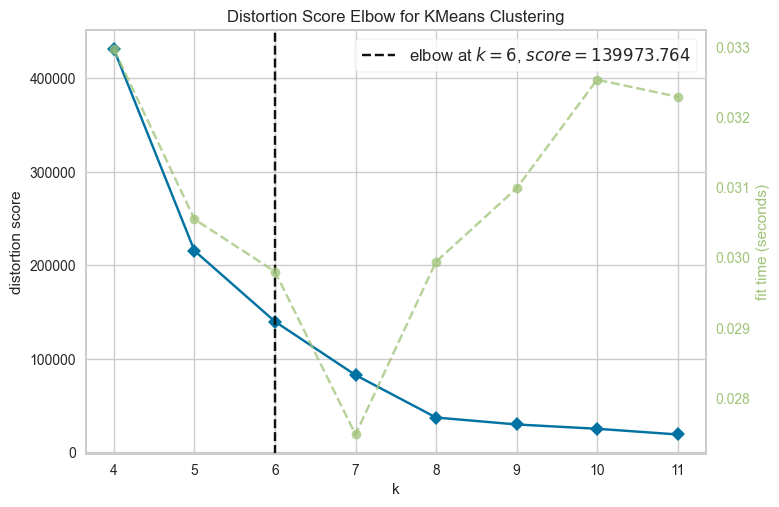

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [300]:
from yellowbrick.cluster import KElbowVisualizer
Elbow_M = KElbowVisualizer(KMeans(random_state=27, n_init=10), k=(4,12))
Elbow_M.fit(data)
Elbow_M.show()

Data Visualization

Plotbox

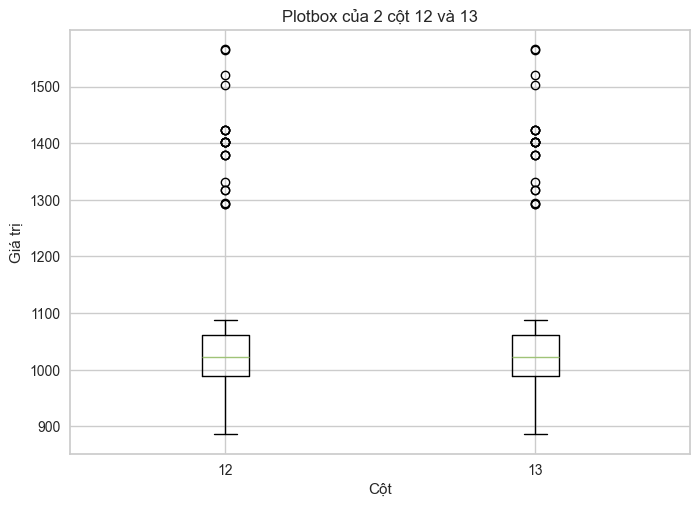

In [301]:
plt.boxplot([data['12'], data['13']], labels=['12', '13'])
plt.xlabel('Cột')
plt.ylabel('Giá trị')
plt.title('Plotbox của 2 cột 12 và 13')
plt.show()

Scatterplot

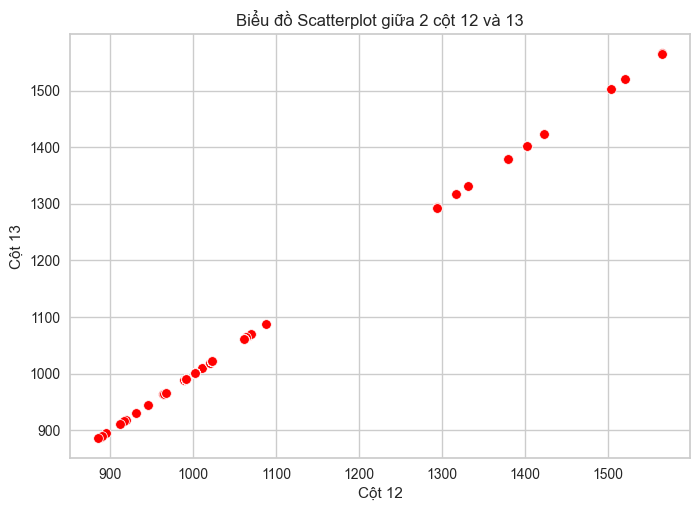

Hệ số tương quan giữa cột 12 và 13 là: 0.9999999963073825


In [302]:
sns.scatterplot(x='12', y='13', data=data, color ='red')
plt.xlabel('Cột 12')
plt.ylabel('Cột 13')
plt.title('Biểu đồ Scatterplot giữa 2 cột 12 và 13')
plt.show()

correlation = data['12'].corr(data['13'])
print(f'Hệ số tương quan giữa cột 12 và 13 là: {correlation}')

Line Graph

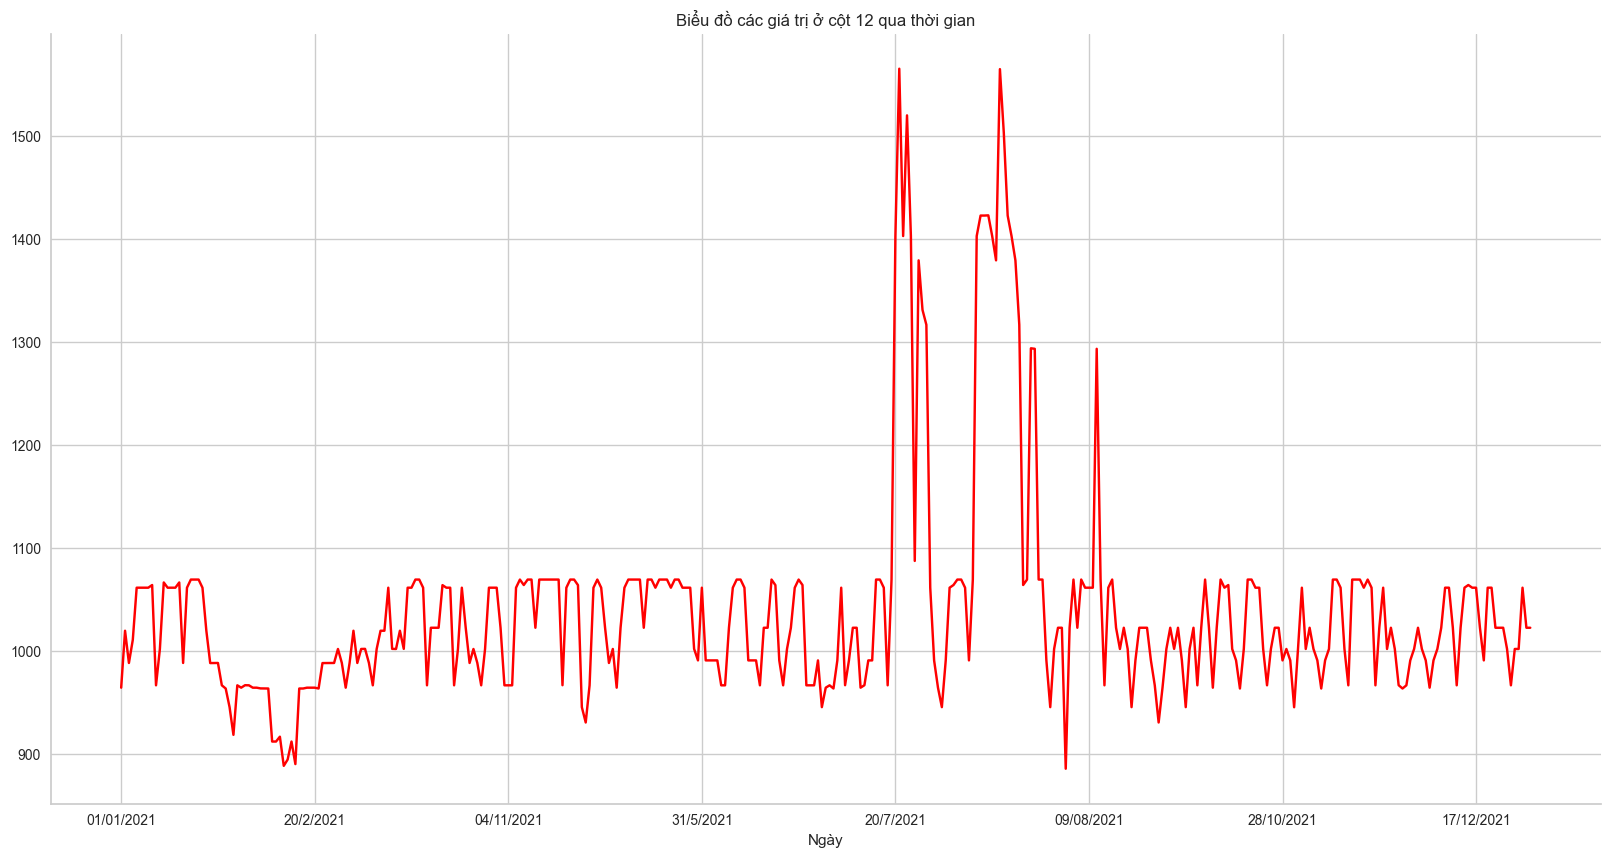

In [303]:
plt.figure(figsize=(20,10))
df['12'].plot(kind = 'line',title="Biểu đồ các giá trị ở cột 12 qua thời gian", color='red')
plt.gca().spines[['top','right']].set_visible(False)

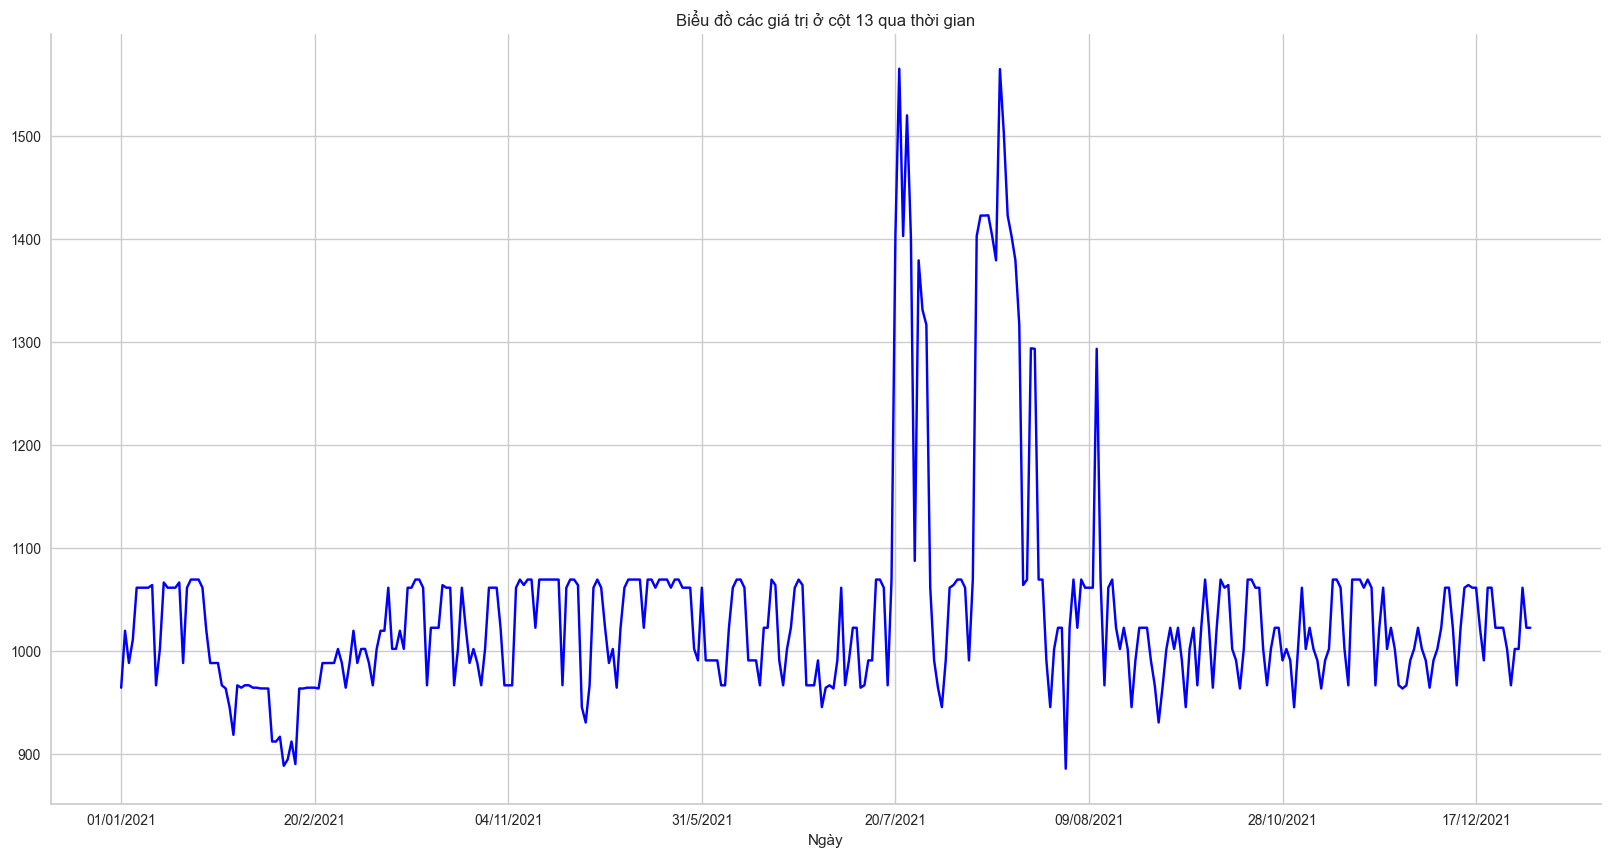

In [304]:
plt.figure(figsize=(20,10))
df['13'].plot(kind = 'line',title="Biểu đồ các giá trị ở cột 13 qua thời gian", color='blue')
plt.gca().spines[['top','right']].set_visible(False)

Sử dụng model

Bayesian Gaussian Mixture

In [305]:
BGM = BayesianGaussianMixture(n_components=7, random_state=27)

preds_bgm = BGM.fit_predict(data)

In [306]:
pp_1=BGM.predict_proba(data)# Calcualting the probabilities of each prediction
df_new1=pd.DataFrame(data) 
df_new1[[f'predict_proba_{i}' for i in range(7)]]=pp_1 # creating new dataframe columns of probabilites 
df_new1['preds']=preds_bgm
df_new1['predict_proba']=np.max(pp_1,axis=1)
df_new1['predict']=np.argmax(pp_1,axis=1)
    
train_index=np.array([])
for n in range(7):
    n_inx=df_new1[(df_new1.preds==n) & (df_new1.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [307]:
from sklearn.model_selection import StratifiedKFold
X_new1=df_new1.loc[train_index]
y1=df_new1.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list1=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new1,y1)):   

    tr_dataset = lgb.Dataset(X_new1.iloc[train_idx],y1.iloc[train_idx])
    vl_dataset = lgb.Dataset(X_new1.iloc[valid_idx],y1.iloc[valid_idx])
    
    model1 = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=400, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list1.append(model1) 

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=11.
  warnings.warn(


[200]	valid_0's multi_logloss: 8.59788e-06
[400]	valid_0's multi_logloss: 8.59788e-06
[200]	valid_0's multi_logloss: 8.61695e-06
[400]	valid_0's multi_logloss: 8.61695e-06
[200]	valid_0's multi_logloss: 5.65141e-06
[400]	valid_0's multi_logloss: 5.65141e-06
[200]	valid_0's multi_logloss: 6.20366e-06
[400]	valid_0's multi_logloss: 6.20366e-06
[200]	valid_0's multi_logloss: 6.91973e-06
[400]	valid_0's multi_logloss: 6.91973e-06
[200]	valid_0's multi_logloss: 6.32939e-06
[400]	valid_0's multi_logloss: 6.32939e-06
[200]	valid_0's multi_logloss: 6.43158e-06
[400]	valid_0's multi_logloss: 6.43158e-06
[200]	valid_0's multi_logloss: 6.55277e-06
[400]	valid_0's multi_logloss: 6.55277e-06
[200]	valid_0's multi_logloss: 6.32982e-06
[400]	valid_0's multi_logloss: 6.32982e-06
[200]	valid_0's multi_logloss: 6.23243e-06
[400]	valid_0's multi_logloss: 6.23243e-06
[200]	valid_0's multi_logloss: 1.87413e-05
[400]	valid_0's multi_logloss: 1.87413e-05


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1464\3316072654.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=np.argmax(lgb_preds1,axis=1), palette='tab10')


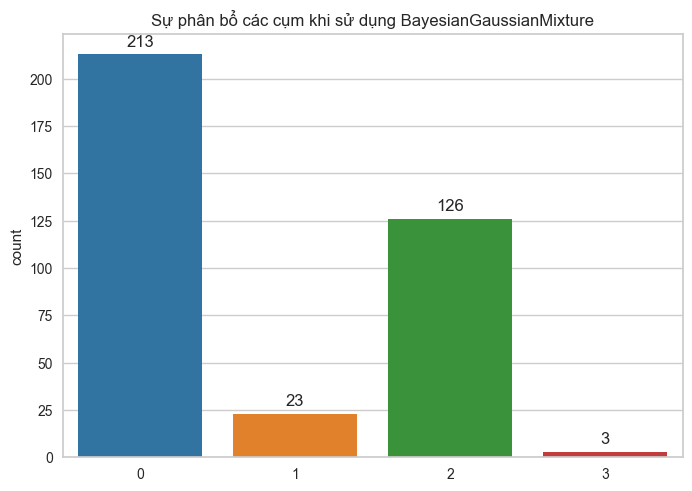

In [308]:
lgb_preds1=0
for model1 in model_list1:
    lgb_preds1+=model1.predict(df_new1)
    
pl = sns.countplot(x=np.argmax(lgb_preds1,axis=1), palette='tab10')
pl.set_title("Sự phân bổ các cụm khi sử dụng BayesianGaussianMixture")
for p in pl.patches:
    pl.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')
plt.show()

Gaussian Mixture

In [309]:
GM = GaussianMixture(n_components=7, random_state=27)

preds_gm = GM.fit_predict(data)

In [310]:
pp_2=GM.predict_proba(data)# Calcualting the probabilities of each prediction
df_new2=pd.DataFrame(data) 
df_new2[[f'predict_proba_{i}' for i in range(7)]]=pp_2 # creating new dataframe columns of probabilites 
df_new2['preds']=preds_gm
df_new2['predict_proba']=np.max(pp_2,axis=1)
df_new2['predict']=np.argmax(pp_2,axis=1)
    
train_index=np.array([])
for n in range(7):
    n_inx=df_new2[(df_new2.preds==n) & (df_new2.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [311]:
X_new2=df_new2.loc[train_index]
y2=df_new2.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list2=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new2,y2)):   

    tr_dataset = lgb.Dataset(X_new2.iloc[train_idx],y2.iloc[train_idx])
    vl_dataset = lgb.Dataset(X_new2.iloc[valid_idx],y2.iloc[valid_idx])
    
    model2 = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list2.append(model2) 

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=11.
  warnings.warn(


[200]	valid_0's multi_logloss: 1.12642e-05
[400]	valid_0's multi_logloss: 1.08532e-05
[600]	valid_0's multi_logloss: 1.08279e-05
[800]	valid_0's multi_logloss: 1.08838e-05
[200]	valid_0's multi_logloss: 1.14942e-05
[400]	valid_0's multi_logloss: 1.12044e-05
[600]	valid_0's multi_logloss: 1.11864e-05
[800]	valid_0's multi_logloss: 1.11829e-05
[1000]	valid_0's multi_logloss: 1.11813e-05
[1200]	valid_0's multi_logloss: 1.11689e-05
[1400]	valid_0's multi_logloss: 1.11507e-05
[1600]	valid_0's multi_logloss: 1.11445e-05
[1800]	valid_0's multi_logloss: 1.11388e-05
[2000]	valid_0's multi_logloss: 1.11338e-05
[2200]	valid_0's multi_logloss: 1.11291e-05
[2400]	valid_0's multi_logloss: 1.11249e-05
[2600]	valid_0's multi_logloss: 1.11211e-05
[2800]	valid_0's multi_logloss: 1.11176e-05
[3000]	valid_0's multi_logloss: 1.11143e-05
[3200]	valid_0's multi_logloss: 1.11113e-05
[3400]	valid_0's multi_logloss: 1.11085e-05
[3600]	valid_0's multi_logloss: 1.11059e-05
[3800]	valid_0's multi_logloss: 1.11035e

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1464\57538456.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=np.argmax(lgb_preds2,axis=1), palette='tab10')


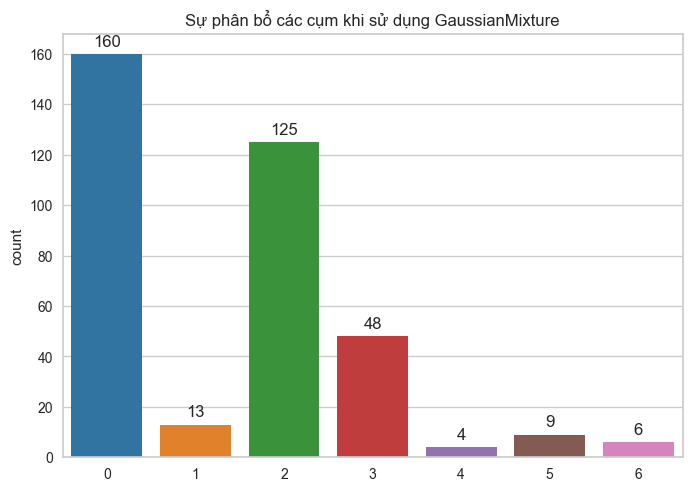

In [312]:
lgb_preds2=0
for model2 in model_list2:
    lgb_preds2+=model2.predict(df_new2)
    
pl = sns.countplot(x=np.argmax(lgb_preds2,axis=1), palette='tab10')
pl.set_title("Sự phân bổ các cụm khi sử dụng GaussianMixture")
for p in pl.patches:
    pl.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')
plt.show()